<a href="https://www.kaggle.com/code/shmel9va/cyclegan?scriptVersionId=261998297" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as FUNC
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, datasets, utils
from PIL import Image
import numpy as np
from tqdm import tqdm
import os
from torchvision.models import inception_v3
from scipy import linalg

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
class ResnetBlock(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.conv_block = nn.Sequential(
            nn.Conv2d(dim, dim, 3, 1, 1, bias=False),
            nn.InstanceNorm2d(dim),
            nn.ReLU(True),
            nn.Conv2d(dim, dim, 3, 1, 1, bias=False),
            nn.InstanceNorm2d(dim),
        )

    def forward(self, x):
        return x + self.conv_block(x)

class ResnetGenerator(nn.Module):
    def __init__(self, input_nc, output_nc, n_blocks=9):
        super().__init__()
        model = [
            nn.Conv2d(input_nc, 64, 7, 1, 3, bias=False),
            nn.InstanceNorm2d(64),
            nn.ReLU(True),
        ]
        # Downsampling
        in_features = 64
        out_features = in_features * 2
        for _ in range(2):
            model += [
                nn.Conv2d(in_features, out_features, 3, 2, 1, bias=False),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(True)
            ]
            in_features = out_features
            out_features = in_features * 2
        # ResNet blocks
        for _ in range(n_blocks):
            model += [ResnetBlock(in_features)]
        # Upsampling
        out_features = in_features // 2
        for _ in range(2):
            model += [
                nn.ConvTranspose2d(in_features, out_features, 3, 2, 1, 1, bias=False),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(True)
            ]
            in_features = out_features
            out_features = in_features // 2
        # Output layer
        model += [
            nn.Conv2d(64, output_nc, 7, 1, 3),
            nn.Tanh()
        ]
        self.model = nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)

In [3]:
class PatchDiscriminator(nn.Module):
    def __init__(self, input_nc):
        super().__init__()
        model = [
            nn.Conv2d(input_nc, 64, 4, 2, 1),
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.InstanceNorm2d(128),
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.InstanceNorm2d(256),
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(256, 512, 4, 1, 1, bias=False),
            nn.InstanceNorm2d(512),
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(512, 1, 4, 1, 1)
        ]
        self.model = nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)

In [4]:
def gan_loss(pred, target_is_real):
    target = torch.ones_like(pred) if target_is_real else torch.zeros_like(pred)
    return FUNC.mse_loss(pred, target)

def cycle_loss(recon, real):
    return FUNC.l1_loss(recon, real)

def identity_loss(idt, real):
    return FUNC.l1_loss(idt, real)

In [5]:
# 3 canals (RGB)
G = ResnetGenerator(3, 3).to(device)  # X->Y
F = ResnetGenerator(3, 3).to(device)  # Y->X
D_X = PatchDiscriminator(3).to(device)
D_Y = PatchDiscriminator(3).to(device)

In [6]:
class MonetDataset(Dataset):
    def __init__(self, root_photo, root_monet, transform, max_photos=None, max_monets=None):
        self.photo_files = sorted(os.listdir(root_photo))
        self.monet_files = sorted(os.listdir(root_monet))
        if max_photos is not None:
            self.photo_files = self.photo_files[:max_photos]
        if max_monets is not None:
            self.monet_files = self.monet_files[:max_monets]
        self.photo_root = root_photo
        self.monet_root = root_monet
        self.transform = transform

    def __len__(self):
        return max(len(self.photo_files), len(self.monet_files))

    def __getitem__(self, idx):
        photo_path = os.path.join(self.photo_root, self.photo_files[idx % len(self.photo_files)])
        monet_path = os.path.join(self.monet_root, self.monet_files[idx % len(self.monet_files)])
        photo = self.transform(Image.open(photo_path).convert('RGB'))
        monet = self.transform(Image.open(monet_path).convert('RGB'))
        return photo, monet


In [7]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

In [8]:
dataset = MonetDataset(
    root_photo="/kaggle/input/gan-getting-started/photo_jpg",
    root_monet="/kaggle/input/gan-getting-started/monet_jpg",
    transform=transform,
    max_photos=300,   
    max_monets=300 
)
loader = DataLoader(dataset, batch_size=8, shuffle=True, num_workers=4)

In [9]:
import torch
import torch.nn as nn
from torch.optim import Adam
from tqdm import tqdm
import os

torch.cuda.empty_cache()  # clear GPU cache

# (1) Training parameters
lr = 2e-4
beta1 = 0.5
num_epochs = 100
save_every = 10  # save checkpoints every 10 epochs
out_dir = "/kaggle/working/checkpoints"
os.makedirs(out_dir, exist_ok=True)

# (2) Optimizers
optimizer_G = Adam(list(G.parameters()) + list(F.parameters()), lr=lr, betas=(beta1, 0.999))
optimizer_D_X = Adam(D_X.parameters(), lr=lr, betas=(beta1, 0.999))
optimizer_D_Y = Adam(D_Y.parameters(), lr=lr, betas=(beta1, 0.999))

lambda_cyc = 10
lambda_id = 5

# (3) Checkpoint saving
def save_checkpoint(G, F, D_X, D_Y, epoch, out_dir=out_dir):
    torch.save(G.state_dict(), f"{out_dir}/G_epoch{epoch}.pth")
    torch.save(F.state_dict(), f"{out_dir}/F_epoch{epoch}.pth")
    torch.save(D_X.state_dict(), f"{out_dir}/D_X_epoch{epoch}.pth")
    torch.save(D_Y.state_dict(), f"{out_dir}/D_Y_epoch{epoch}.pth")
    print(f"[✓] Saved at epoch {epoch}")

# (4) Loss logs
from collections import defaultdict
losses = defaultdict(list)

# (5) Training loop
for epoch in range(1, num_epochs + 1):
    G.train(); F.train(); D_X.train(); D_Y.train()
    tq = tqdm(loader, desc=f"Epoch {epoch}/{num_epochs}")
    for real_x, real_y in tq:
        real_x, real_y = real_x.to(device), real_y.to(device)

        # Generators
        optimizer_G.zero_grad()
        idt_y = G(real_y)
        idt_x = F(real_x)
        loss_idt_y = identity_loss(idt_y, real_y) * lambda_id
        loss_idt_x = identity_loss(idt_x, real_x) * lambda_id
        fake_y = G(real_x)
        fake_x = F(real_y)
        pred_fake_y = D_Y(fake_y)
        pred_fake_x = D_X(fake_x)
        loss_GAN_G = gan_loss(pred_fake_y, True)
        loss_GAN_F = gan_loss(pred_fake_x, True)
        rec_x = F(fake_y)
        rec_y = G(fake_x)
        loss_cycle_x = cycle_loss(rec_x, real_x) * lambda_cyc
        loss_cycle_y = cycle_loss(rec_y, real_y) * lambda_cyc
        loss_G = loss_GAN_G + loss_GAN_F + loss_cycle_x + loss_cycle_y + loss_idt_x + loss_idt_y
        loss_G.backward()
        optimizer_G.step()

        # Discriminator D_Y
        optimizer_D_Y.zero_grad()
        pred_real_y = D_Y(real_y)
        pred_fake_y = D_Y(fake_y.detach())
        loss_D_Y = (gan_loss(pred_real_y, True) + gan_loss(pred_fake_y, False)) * 0.5
        loss_D_Y.backward()
        optimizer_D_Y.step()

        # Discriminator D_X
        optimizer_D_X.zero_grad()
        pred_real_x = D_X(real_x)
        pred_fake_x = D_X(fake_x.detach())
        loss_D_X = (gan_loss(pred_real_x, True) + gan_loss(pred_fake_x, False)) * 0.5
        loss_D_X.backward()
        optimizer_D_X.step()

        # Track losses
        losses['G'].append(loss_G.item())
        losses['D_X'].append(loss_D_X.item())
        losses['D_Y'].append(loss_D_Y.item())
        losses['loss_idt_x'].append(loss_idt_x.item())
        losses['loss_idt_y'].append(loss_idt_y.item())
        losses['loss_cycle_x'].append(loss_cycle_x.item())
        losses['loss_cycle_y'].append(loss_cycle_y.item())

        # Show losses in progress bar
        tq.set_postfix({
            'G': f'{loss_G.item():.3f}',
            'D_X': f'{loss_D_X.item():.3f}',
            'D_Y': f'{loss_D_Y.item():.3f}'
        })

    # Save checkpoints
    if epoch % save_every == 0 or epoch == num_epochs:
        save_checkpoint(G, F, D_X, D_Y, epoch, out_dir=out_dir)

    # Clear GPU cache
    torch.cuda.empty_cache()

print("Training finished!")

# Save losses for plotting later
import pickle
with open(f"{out_dir}/losses.pkl", "wb") as f:
    pickle.dump(dict(losses), f)

Epoch 10/100: 100%|██████████| 38/38 [01:14<00:00,  1.97s/it, G=6.181, D_X=0.227, D_Y=0.182]


[✓] Saved at epoch 10


Epoch 20/100: 100%|██████████| 38/38 [01:14<00:00,  1.97s/it, G=6.037, D_X=0.103, D_Y=0.162]


[✓] Saved at epoch 20


Epoch 30/100: 100%|██████████| 38/38 [01:14<00:00,  1.97s/it, G=5.439, D_X=0.184, D_Y=0.202]


[✓] Saved at epoch 30


Epoch 40/100: 100%|██████████| 38/38 [01:14<00:00,  1.97s/it, G=5.330, D_X=0.071, D_Y=0.278]


[✓] Saved at epoch 40


Epoch 50/100: 100%|██████████| 38/38 [01:14<00:00,  1.97s/it, G=3.980, D_X=0.172, D_Y=0.196]


[✓] Saved at epoch 50


Epoch 60/100: 100%|██████████| 38/38 [01:14<00:00,  1.97s/it, G=4.687, D_X=0.157, D_Y=0.093]


[✓] Saved at epoch 60


Epoch 70/100: 100%|██████████| 38/38 [01:14<00:00,  1.97s/it, G=4.443, D_X=0.055, D_Y=0.053]


[✓] Saved at epoch 70


Epoch 80/100: 100%|██████████| 38/38 [01:14<00:00,  1.97s/it, G=3.816, D_X=0.129, D_Y=0.146]


[✓] Saved at epoch 80


Epoch 90/100: 100%|██████████| 38/38 [01:14<00:00,  1.97s/it, G=4.382, D_X=0.258, D_Y=0.111]


[✓] Saved at epoch 90


Epoch 100/100: 100%|██████████| 38/38 [01:14<00:00,  1.97s/it, G=4.797, D_X=0.186, D_Y=0.055]


[✓] Saved at epoch 100
Training finished!


In [10]:
# MiFID
from torchvision.models import inception_v3
import torch.nn as nn

def get_inception_features(images, model, batch_size=8):
    features = []
    model.eval()
    with torch.no_grad():
        for i in range(0, images.shape[0], batch_size):
            batch = images[i:i+batch_size].to(device)
            batch = FUNC.interpolate(batch, size=(299, 299), mode='bilinear', align_corners=False)
            preds = model(batch)
            if isinstance(preds, tuple):  # for older torchvision versions
                preds = preds[0]
            preds = preds.detach().cpu().numpy()
            features.append(preds)
    features = np.concatenate(features, axis=0)
    return features

def calculate_fid(mu1, sigma1, mu2, sigma2, eps=1e-6):
    diff = mu1 - mu2
    covmean, _ = linalg.sqrtm(sigma1 @ sigma2, disp=False)
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    fid = diff.dot(diff) + np.trace(sigma1 + sigma2 - 2 * covmean)
    return fid

def compute_mifid(genA, realA, genB, realB, batch_size=8):
    # genA: G(X) — photos translated into Monet style
    # realA: real Monet paintings
    # genB: F(Y) — paintings translated into photo style
    # realB: real photos

    # load Inception only once
    model = inception_v3(pretrained=False, transform_input=False).to(device)
    model.load_state_dict(torch.load("/kaggle/input/inception-v3-google-0cc3c7bd-pth/inception_v3_google-0cc3c7bd.pth"))
    model.fc = nn.Identity()
    model.eval()

    # FID(G(X), Y)
    feats1 = get_inception_features(genA, model, batch_size)
    feats2 = get_inception_features(realA, model, batch_size)
    mu1, sigma1 = feats1.mean(axis=0), np.cov(feats1, rowvar=False)
    mu2, sigma2 = feats2.mean(axis=0), np.cov(feats2, rowvar=False)
    fid_A = calculate_fid(mu1, sigma1, mu2, sigma2)

    # FID(F(Y), X)
    feats1 = get_inception_features(genB, model, batch_size)
    feats2 = get_inception_features(realB, model, batch_size)
    mu1, sigma1 = feats1.mean(axis=0), np.cov(feats1, rowvar=False)
    mu2, sigma2 = feats2.mean(axis=0), np.cov(feats2, rowvar=False)
    fid_B = calculate_fid(mu1, sigma1, mu2, sigma2)

    # MiFID = sum of both directions
    mifid = fid_A + fid_B
    return mifid, fid_A, fid_B

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/torchvision/models/inception.py:43: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(


MiFID: 233.0990 (FID_XY=117.0533, FID_YX=116.0457)


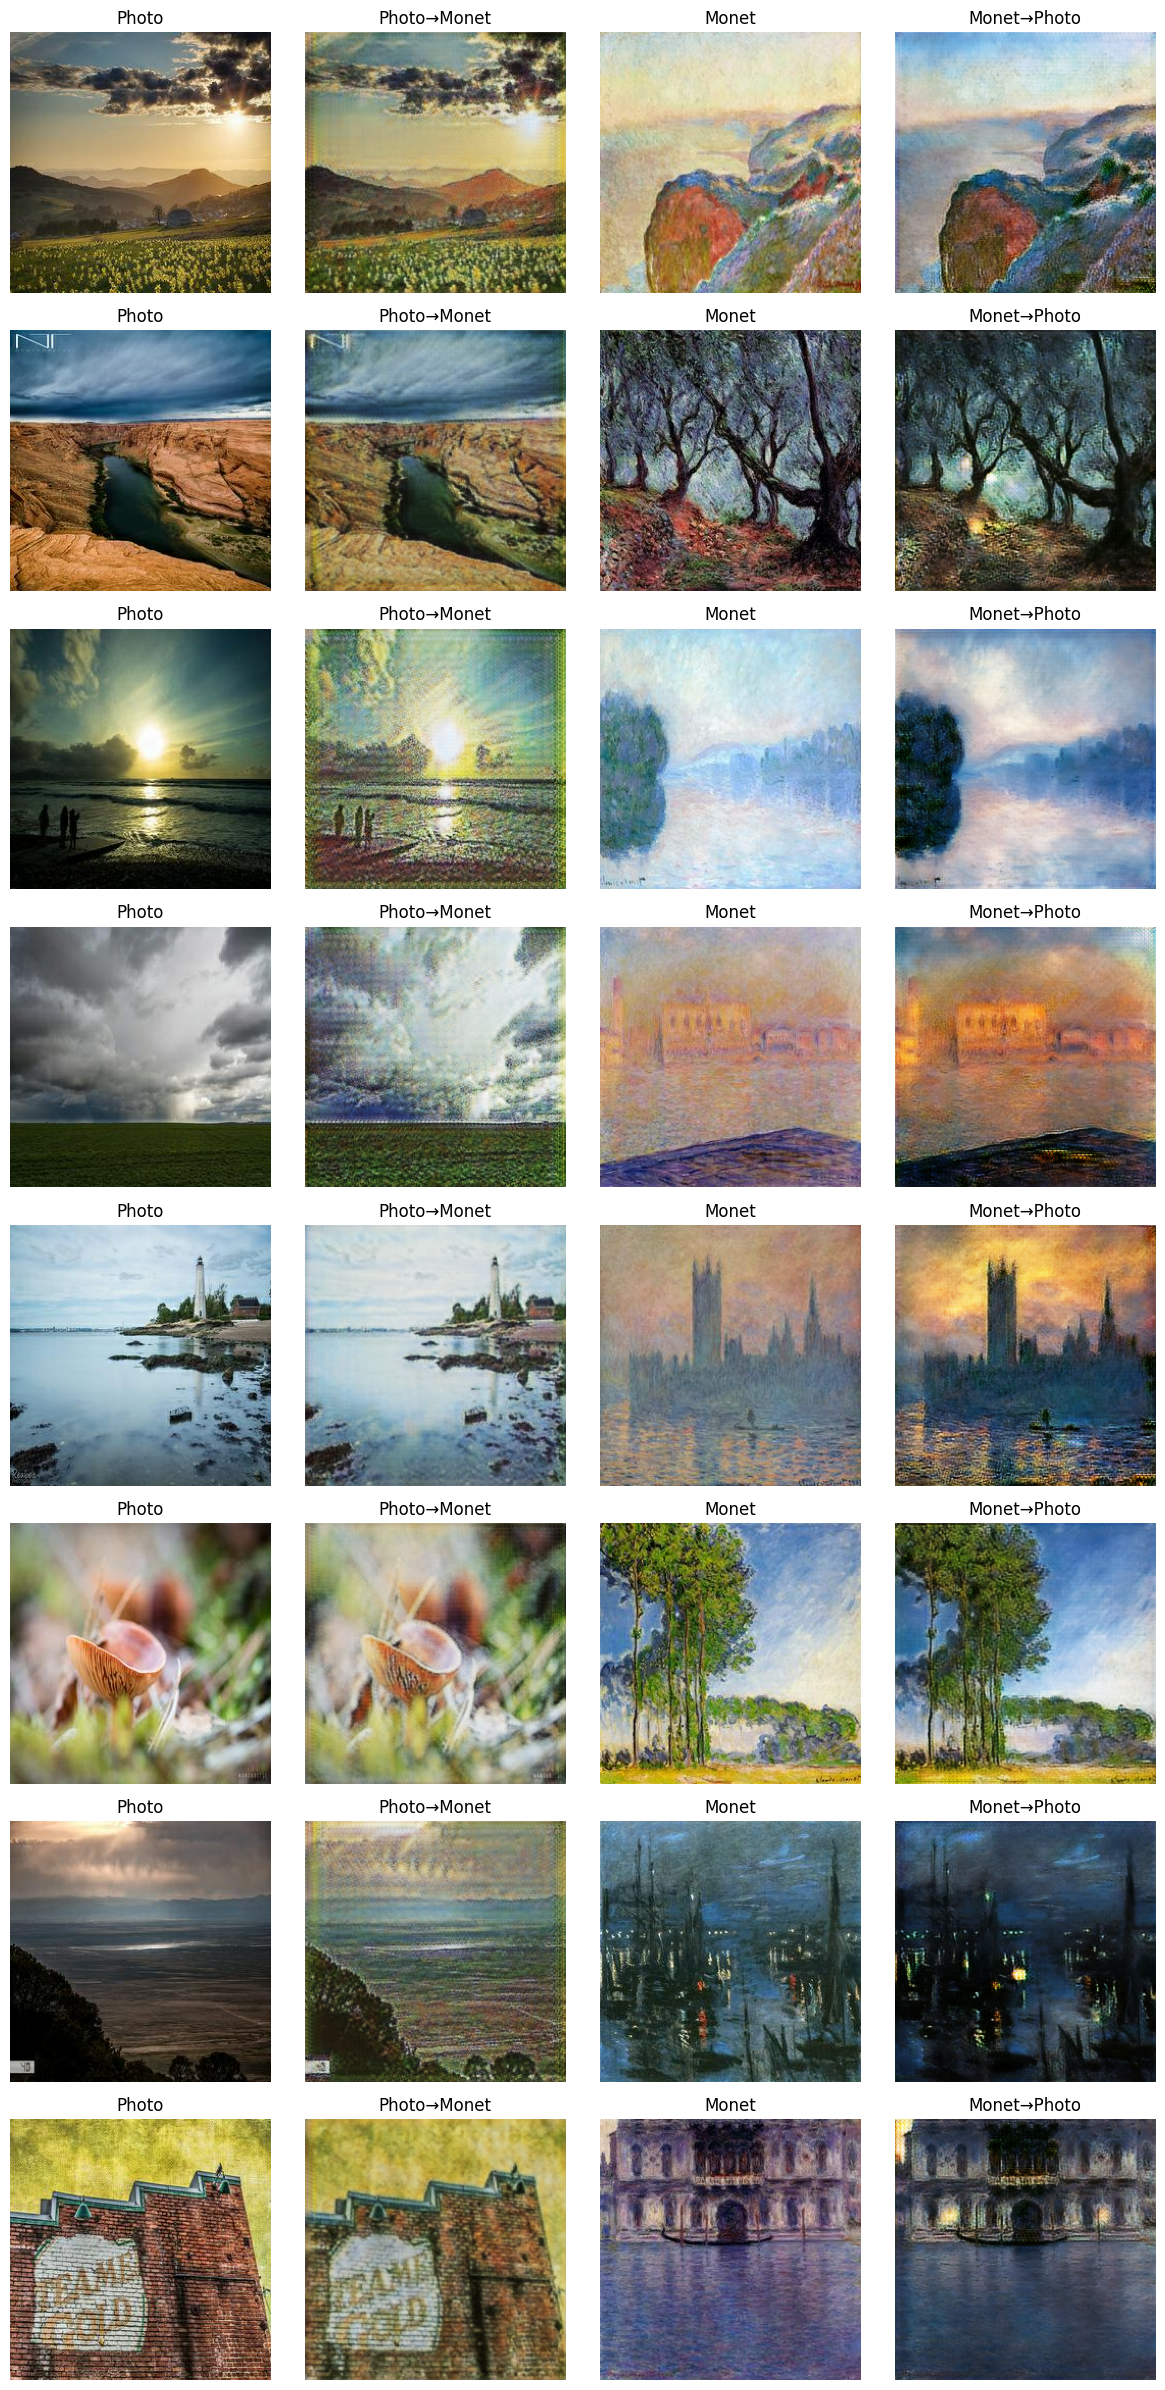

In [11]:
N = 300
photos, monets = [], []
for i in range(N):
    photo, monet = dataset[i]
    photos.append(photo)
    monets.append(monet)

test_photos = torch.stack(photos)
test_monet = torch.stack(monets)

with torch.no_grad():
    fake_monet = G(test_photos.to(device)).cpu()   # G(X): photo → Monet
    rec_photos = F(test_monet.to(device)).cpu()    # F(Y): Monet → photo

# MiFID evaluation
mifid, fid_xy, fid_yx = compute_mifid(
    fake_monet, test_monet,      # G(X), Y
    rec_photos, test_photos,     # F(Y), X
    batch_size=32
)
print(f"MiFID: {mifid:.4f} (FID_XY={fid_xy:.4f}, FID_YX={fid_yx:.4f})")

# Visualization of the first N samples
N_vis = 8

def denorm(t):
    t = (t * 0.5) + 0.5
    return t.clamp(0, 1).permute(1, 2, 0).numpy()

import matplotlib.pyplot as plt
fig, axs = plt.subplots(N_vis, 4, figsize=(12, 3 * N_vis))
if N_vis == 1:
    axs = axs.reshape(1, 4)

for i in range(N_vis):
    axs[i, 0].imshow(denorm(test_photos[i]))
    axs[i, 0].set_title('Photo')
    axs[i, 0].axis('off')

    axs[i, 1].imshow(denorm(fake_monet[i]))
    axs[i, 1].set_title('Photo→Monet')
    axs[i, 1].axis('off')

    axs[i, 2].imshow(denorm(test_monet[i]))
    axs[i, 2].set_title('Monet')
    axs[i, 2].axis('off')

    axs[i, 3].imshow(denorm(rec_photos[i]))
    axs[i, 3].set_title('Monet→Photo')
    axs[i, 3].axis('off')

plt.tight_layout()
plt.show()

In [12]:
dataset = MonetDataset(
    root_photo="/kaggle/input/gan-getting-started/photo_jpg",
    root_monet="/kaggle/input/gan-getting-started/monet_jpg",
    transform=transform,
    max_photos=7000,   
    max_monets=300 
)

In [13]:
# 1. Create and load the generator
G = ResnetGenerator(3, 3).to(device)
state = torch.load("/kaggle/working/checkpoints/G_epoch100.pth", map_location=device)
try:
    G.load_state_dict(state)
except RuntimeError:
    from collections import OrderedDict
    new_state = OrderedDict()
    for k, v in state.items():
        name = k.replace('module.', '')
        new_state[name] = v
    G.load_state_dict(new_state)
G.eval()

# 2. Generation
max_gen = 7000
photo_files = dataset.photo_files[:max_gen]
output_dir = "/kaggle/working/gen_images"
os.makedirs(output_dir, exist_ok=True)

photo_files = dataset.photo_files[:max_gen]
for i, photo_name in enumerate(tqdm(photo_files)):
    img_path = os.path.join(dataset.photo_root, photo_name)
    img = Image.open(img_path).convert('RGB')
    tensor = transform(img).unsqueeze(0).to(device)
    with torch.no_grad():
        fake_monet = G(tensor).cpu().squeeze(0)
    img_np = (fake_monet * 0.5 + 0.5).clamp(0, 1).numpy().transpose(1, 2, 0)
    img_np = (img_np * 255).astype(np.uint8)
    Image.fromarray(img_np).save(f"{output_dir}/{i:05d}.jpg", "JPEG")

# 3. Archive results
import shutil
shutil.make_archive("/kaggle/working/images", 'zip', output_dir)

100%|██████████| 7000/7000 [02:49<00:00, 41.35it/s]


'/kaggle/working/images.zip'